In [1]:
import os
import sys
from pathlib import Path
path = str(Path(os.getcwd()))
sys.path.insert(1, path+'/amazon-braket-community-detection/src')

In [2]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic
import networkx as nx

df = pd.read_csv(path+'/database/SolarPowerPlants_TH.csv', delimiter=',', skiprows=1)
df

,WKT,Index,latitude,longitude,name,capacity(MW)
0,POINT (100.1995973 13.5797688),1,13.579769,100.199597,Samut Sakhon,5.0
1,POINT (100.4800113 13.7131258),2,13.713126,100.480011,The Mall - Tha Phra,1.0
2,POINT (100.4474445 13.8199492),3,13.819949,100.447445,Ratchaphruek,1.0
3,POINT (100.5417601 13.8550947),4,13.855095,100.541760,The Mall - Ngamwongwan,1.0
4,POINT (100.6421705 13.7658514),5,13.765851,100.642171,The Mall - Bangkapi,1.0
5,POINT (100.6798205 13.8282182),6,13.828218,100.679821,Akekamai-Ramintra,1.0
6,POINT (101.0033703 13.5759609),7,13.575961,101.003370,Chachoengsao,1.3
7,POINT (100.5528226 14.1690859),8,14.169086,100.552823,Bangchak,16.0
8,POINT (100.5530586 14.1689819),9,14.168982,100.553059,Bangchak III,25.0
9,POINT (100.1837652 13.9754302),10,13.975430,100.183765,Sai Thong,6.1


In [3]:
ind = df['Index']
name = df['name']
lat = df['latitude']
long = df['longitude']
capacity = df['capacity(MW)']

In [4]:
locations = {ind: (lat, long) for ind, lat, long in zip(ind, lat, long)}
locations

{1: (13.5797688, 100.1995973),
 2: (13.7131258, 100.4800113),
 3: (13.8199492, 100.4474445),
 4: (13.8550947, 100.5417601),
 5: (13.7658514, 100.6421705),
 6: (13.8282182, 100.6798205),
 7: (13.5759609, 101.0033703),
 8: (14.1690859, 100.5528226),
 9: (14.1689819, 100.5530586),
 10: (13.9754302, 100.1837652),
 11: (13.9840662, 100.1962857),
 12: (14.0004893, 100.200201),
 13: (14.1076288, 100.1737777),
 14: (14.1367617, 100.1432434),
 15: (14.1383847, 100.1506249),
 16: (14.1542604, 100.1377288),
 17: (14.2224476, 100.1128729),
 18: (14.2446193, 100.1275879),
 19: (14.3219005, 100.3022163),
 20: (14.2172742, 100.2778664)}

In [5]:
(len(locations.keys()))

20

In [6]:

# noconsumers = 10
# c_energy = np.random.default_rng().normal(loc=np.average(capacity), scale=np.std(capacity)/2, size=noconsumers)
# # c_energy = np.random.default_rng().integers(low=min(capacity), high=max(capacity), size=10)
# c_energy

In [18]:
def calculate_distance_mgpp(mglat, mglong, pplat, pplong):    
    distance_matrix = np.zeros(len(pplat))
    for i in range(len(pplat)):
        distance_matrix[i] = geodesic((mglat, mglong), (pplat[i], pplong[i])).km
    return distance_matrix


In [8]:
def calculate_distance_mgmg(mglat, mglong):    
    distance_matrix = np.zeros((len(mglat), len(mglat)))
    for i in range(len(mglat)):
        for j in range(len(mglat)):
            if i < j:
                distance_matrix[i][j] = geodesic((mglat[i], mglong[i]), (mglat[j], mglong[j])).km
    return distance_matrix

In [9]:
def create_transmission_network(locations, distance_matrix, threshold=45):
    G = nx.Graph()
    for i, label_i in enumerate(locations.keys()):
        for j, label_j in enumerate(locations.keys()):
            if i < j:
                if distance_matrix[i][j] < threshold: # Only add edge if distance is below threshold
                    G.add_edge(label_i, label_j)
    return G

In [10]:
print(enumerate(locations.keys()))

In [12]:
# distance_matrix = calculate_distance_matrix(lat, long)

# # Create Graph Based on Distance Threshold
# G = create_transmission_network(locations, distance_matrix, threshold=45)

# # Visualize Graph
# fig, ax = plt.subplots()
# pos = {label: (lon, lat) for label, (lat, lon) in locations.items()}
# nx.draw(G, pos, ax=ax, node_size=100, node_color='blue')
# # nx.draw(G, pos, ax=ax, node_size=800, with_labels=True)
# # with_labels=True, node_color='lightblue', node_size=800)
# plt.title("Solar Panel Proximity Graph")
# plt.show()

In [ ]:
# total_nodes = len(G.nodes(data=True))
# total_edges = len(G.edges(data=True))

In [ ]:
import scipy.sparse as sp
from networkx.algorithms import community

### create QUBO matrix
# define the distance matrix
num_powerplants = (len(locations.keys())) ## number of solar power plants
pplat, pplong = zip(*locations.values())

In [14]:
# generate choices for microgrid locations
num_microgrids = 20 ## number of microgrids
random_lat = np.random.uniform(min(lat), max(lat), size=4*num_microgrids)
lat_choices = np.random.choice(random_lat, size=num_microgrids, replace=False)

random_long = np.random.uniform(min(long), max(long), size=4*num_microgrids)
long_choices = np.random.choice(random_long, size=num_microgrids, replace=False)

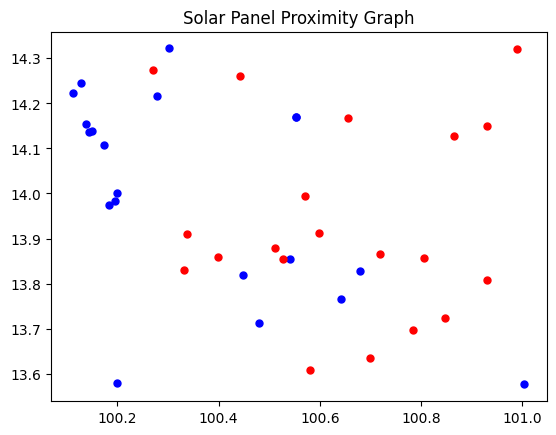

In [15]:
# Visualize Graph
fig, ax = plt.subplots()
ax.plot(long, lat, 'o', markersize=5, color='blue')
ax.plot(long_choices, lat_choices, 'o', markersize=5, color='red')
plt.title("Solar Panel Proximity Graph")
plt.show()

In [16]:
i=0
mgpp_distance = calculate_distance_mgpp(lat_choices[i], long_choices[i],pplat, pplong)
mgpp_distance

array([64.46915991, 30.85308571, 29.83216333, 19.25155552, 13.76196422,
        5.88825864, 44.29308131, 38.20368723, 38.18152424, 59.19120468,
       58.07710857, 58.10670875, 64.81092829, 69.16399808, 68.52597795,
       70.5567392 , 76.56533957, 76.52669704, 67.76093535, 61.63692012])

In [17]:
mgmg_distance = calculate_distance_mgmg(lat_choices, long_choices)
mgmg_distance

array([[ 0.        , 53.17234796, 66.32371485, 33.02556399, 31.99189238,
        34.63143781, 25.46211619, 14.1568824 ,  9.25791071, 19.78760135,
        41.98551582, 20.75584163, 20.83086021, 38.92104567, 22.53131018,
        34.13714589, 58.26563484, 41.54546756, 23.53564737, 21.58675173],
       [ 0.        ,  0.        , 18.48200548, 48.00332564, 73.7591111 ,
        44.7677008 , 74.63231253, 42.19333933, 59.42363565, 72.55518926,
        49.13977307, 45.9449753 , 73.8700617 , 54.05442027, 42.99483745,
        25.26895105, 59.31423491, 40.60942302, 72.67272898, 32.69327557],
       [ 0.        ,  0.        ,  0.        , 66.1104884 , 80.88372564,
        47.97187345, 84.44966531, 53.40371751, 73.78967228, 84.53789554,
        49.5574281 , 54.05262985, 87.09639793, 72.37766256, 50.8651074 ,
        43.09335602, 77.54389338, 41.06414962, 87.79436923, 44.75194309],
       [ 0.        ,  0.        ,  0.        ,  0.        , 65.01682844,
        58.40213118, 57.30167361, 37.41812282, 3

In [19]:
costCoeff = 10000
mgpp_cost = mgpp_distance * costCoeff
mgmg_cost = mgmg_distance * costCoeff

battery_cost = 38000  # Example fixed cost for battery and inverter installation
solar_cost = 15000  # Example fixed cost for solar panel installation
fixedCost = battery_cost + solar_cost